In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

### 📒 Data Loading and Initial Exploration


In [2]:
# Load Data
train = pd.read_csv(r'C:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\Data\raw\train.csv', 
                    parse_dates=['Date'])

store = pd.read_csv(r'C:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\Data\raw\store.csv')

test = pd.read_csv(r'C:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\Data\raw\test.csv', 
                   parse_dates=['Date'])


# merge supplementary store data with training data 
df = train.merge(store, on='Store', how='left')

# Print the shape of our data
print(df.shape)

# Drop closed stores when  open==0 for modeling sales
df = df[df['Open'] != 0]

C:\Users\Alex Marco\AppData\Local\Temp\ipykernel_1200\2068382585.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r'C:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\Data\raw\train.csv',


(1017209, 18)


In [3]:
# store-based sampling (choose 300 stores randomly)
sampled_stores = df["Store"].drop_duplicates().sample(300, random_state=42)
df_sample = df[df["Store"].isin(sampled_stores)]

print("Original shape:", df.shape)
print("Sampled shape:", df_sample.shape)

Original shape: (844392, 18)
Sampled shape: (229566, 18)


### 📒 Feature Engineering and Data Cleaning

In [17]:


# Generate date features from 'Date' column
df_sample["Year"] = df_sample["Date"].dt.year
df_sample["Month"] = df_sample["Date"].dt.month
df_sample["Day"] = df_sample["Date"].dt.day
df_sample["DayOfWeek"] = df_sample["Date"].dt.dayofweek + 1  # keep 1–7 format
df_sample["WeekOfYear"] = df_sample["Date"].dt.isocalendar().week.astype(int)
df_sample["is_month_start"] = df_sample["Date"].dt.is_month_start.astype(int)
df_sample["is_month_end"] = df_sample["Date"].dt.is_month_end.astype(int)
# Purpose: Sales often depend on time patterns (seasonality, holidays, paydays, weekends).


# Competition Features and filling missing values, then convert to integer for later calculation
comp_year = df_sample["CompetitionOpenSinceYear"].fillna(0).astype(int)
comp_month = df_sample["CompetitionOpenSinceMonth"].fillna(1).astype(int)
# We comobine the comp_year and comp_month to datetime
comp_open = pd.to_datetime(
    comp_year.astype(str) + "-" + comp_month.astype(str) + "-01",
    errors="coerce"
)

#e"].dt.month - com Creates competition age feature that tells the month since competitor opened.
df_sample["CompetitionOpenSinceMonths"] = (
    (df_sample["Date"].dt.year - comp_open.dt.year) * 12 +
    (df_sample["Date"].dt.month - comp_open.dt.month)
)

# Replace negative values of future competition and missing with 0
df_sample["CompetitionOpenSinceMonths"] = df_sample["CompetitionOpenSinceMonths"].clip(lower=0).fillna(0)
# Purpose: Longer competition presence might reduce store sales


# Promo2 Features and filling missing values
# Promo2SinceWeek and Promo2SinceYear can have NaNs when Promo2==0
df_sample["Promo2SinceWeeks"] = 0
mask = (df_sample["Promo2"] == 1) & df_sample["Promo2SinceYear"].notna() & df_sample["Promo2SinceWeek"].notna()

# Build a start date: ISO year + week + Monday as the start of that week
promo2_start = pd.to_datetime(
    df_sample.loc[mask, "Promo2SinceYear"].astype(int).astype(str) + "-" +
    df_sample.loc[mask, "Promo2SinceWeek"].astype(int).astype(str) + "-1",
    format="%G-%V-%u",   # ISO year-week-weekday
    errors="coerce"
)

# Compute weeks since promo started
df_sample.loc[mask, "Promo2SinceWeeks"] = (
    (df_sample.loc[mask, "Date"] - promo2_start).dt.days // 7
).clip(lower=0).fillna(0)




# sort for lag generation
df_sample = df_sample.sort_values(["Store", "Date"])

# Generate lag features (examples: 7, 14, 28 day lag) (Past Sale as our Predictor)
for lag in [7, 14, 28]:
    df_sample[f"lag_{lag}"] = df_sample.groupby("Store")["Sales"].shift(lag)

# Rolling statistics (moving averages & std) to avoid data leakage
df_sample["roll_mean_7"] = df_sample.groupby("Store")["Sales"].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
df_sample["roll_mean_28"] = df_sample.groupby("Store")["Sales"].shift(1).rolling(28).mean().reset_index(level=0, drop=True)
df_sample["roll_std_7"] = df_sample.groupby("Store")["Sales"].shift(1).rolling(7).std().reset_index(level=0, drop=True)
# Capture trend/smoothness in sales.

# Drop rows with missing lag/rolling values
df_sample = df_sample.dropna(subset=["lag_7", "roll_mean_7"])



# Create a list for the numerical and categorical columns.
# Because ColumsTransformer needs to know which columns to apply the transformations to.
num_cols = [
    "Customers", "CompetitionDistance", "CompetitionOpenSinceMonths",
    "Promo", "Promo2", "Promo2SinceWeeks",
    "Year", "Month", "Day", "DayOfWeek", "WeekOfYear",
    "lag_7", "lag_14", "lag_28",
    "roll_mean_7", "roll_mean_28", "roll_std_7",
    "is_month_start", "is_month_end"
]
cat_cols = ["StoreType", "Assortment", "StateHoliday", "SchoolHoliday"]

# Convert categorical to string
for col in cat_cols:
    df_sample[col] = df_sample[col].astype(str)



print("Feature engineering complete!")
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Final shape:", df_sample.shape)




print("Sales min:", df_sample["Sales"].min())
print("Sales max:", df_sample["Sales"].max())
print("Sales mean:", df_sample["Sales"].mean())
print("log1p(Sales) mean:", np.log1p(df_sample["Sales"]).mean())


Feature engineering complete!
Numeric columns: ['Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonths', 'Promo', 'Promo2', 'Promo2SinceWeeks', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'lag_7', 'lag_14', 'lag_28', 'roll_mean_7', 'roll_mean_28', 'roll_std_7', 'is_month_start', 'is_month_end']
Categorical columns: ['StoreType', 'Assortment', 'StateHoliday', 'SchoolHoliday']
Final shape: (11432, 32)
Sales min: 703
Sales max: 29007
Sales mean: 7309.903866340098
log1p(Sales) mean: 8.810828451431405


### 📒 Model Pipeline

In [5]:
from joblib import Memory
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [6]:


# Define our X features and Target Variable
X = df_sample[num_cols + cat_cols]
y = np.log1p(df_sample["Sales"])  # log-transform target
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)

Training set shape: (40936, 23)


In [7]:


# Cache to avoid recomputing preprocessing
memory = Memory("./cachedir", verbose=0)

num_cols = X_train.select_dtypes(include=["int64", "float64", "bool"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns


# Preprocessing for numerical data
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

# Model pipeline
model = Pipeline(memory=memory, steps=[
    ("preprocessor", preprocessor),
    ("regressor", lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])


# Fit the preprocessor on training data
preprocessor.fit(X_train)

# Transform validation data
X_val_preprocessed = preprocessor.transform(X_val)

# Build model pipeline
model = Pipeline(memory=memory, steps=[
    ("preprocessor", preprocessor),
    ("regressor", lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit pipeline
model.fit(
    X_train, y_train,
    **{
        "regressor__eval_set": [(X_val_preprocessed, y_val)],
        "regressor__eval_metric": "rmse",
        "regressor__callbacks": [
            lgb.early_stopping(50),
            lgb.log_evaluation(50)
        ]
    }
)


# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 40936, number of used features: 26
[LightGBM] [Info] Start training from score 8.811295
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.134275	valid_0's l2: 0.0180298
[100]	valid_0's rmse: 0.106368	valid_0's l2: 0.0113142
[150]	valid_0's rmse: 0.0927044	valid_0's l2: 0.0085941
[200]	valid_0's rmse: 0.0856122	valid_0's l2: 0.00732945
[250]	valid_0's rmse: 0.0804877	valid_0's l2: 0.00647827
[300]	valid_0's rmse: 0.076893	valid_0's l2: 0.00591253
[350]	valid_0's rmse: 0.0739336	valid_0's l2: 0.00546618
[400]	valid_0's rmse: 0.0718154	valid_0's l2: 0.00515745
[450]	valid_0's rmse: 0.0701041	valid_0's l2: 0.00491458
[500]	valid_0's rmse: 0.068

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation RMSE: 0.0633


In [8]:
# inverse-transform the log1p to get actual sales values
y_val_exp = np.expm1(y_val) 
y_pred_exp = np.expm1(y_pred)
# Calculate RMSE on the original scale
rmse_exp = np.sqrt(mean_squared_error(y_val_exp, y_pred_exp))
print(f"Validation RMSE (original scale): {rmse_exp:.2f}")

Validation RMSE (original scale): 488.91


### 📒 Cross Validation

In [9]:
# TimeSeriesSplit for cross-validation on time series data
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer

In [10]:



# Cross Validation TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)
# Use negative RMSE because cross_val_score expects a score (higher is better)
def neg_rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

# Custom scoring function for cross-validation
scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)), 
    greater_is_better=True)


# Use the pipeline 'model' preprocessor + LGBM
cv_scores = cross_val_score(model, X, y, cv=tss, scoring=scorer, n_jobs=-1)
scores= -cv_scores  # Convert back to positive RMSE
print(f"Cross-validated RMSE scores: {scores}")
print(f"Mean CV RMSE: {scores.mean():.4f}, Std: {scores.std():.4f}")

Cross-validated RMSE scores: [0.16787661 0.17926865 0.15315427]
Mean CV RMSE: 0.1668, Std: 0.0107


### 📒 Hyperparameter Turning

In [11]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import copy

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:


# Time series split
tss = TimeSeriesSplit(n_splits=3)

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 5.0, log=True),
        "random_state": 42,
    }


    rmses = []
    for train_idx, val_idx in tss.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]  # safe with pandas

        # Clone pipeline
        pipe = copy.deepcopy(model)

        # Set parameters
        pipe.named_steps['regressor'].set_params(**params)


        # Fit model on log-transformed target
        pipe.fit(X_tr, np.log1p(y_tr))

        # Predict (on log scale)
        preds_log = pipe.predict(X_val)

        # Convert predictions back to original sales scale
        preds_exp = np.expm1(preds_log)


       # Evaluate RMSE on original scale
        rmse = np.sqrt(mean_squared_error(y_val, preds_exp))
        rmses.append(rmse)
        
    return np.mean(rmses)  # Average RMSE across folds



# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Report best trial
print("Best trial parameters:", study.best_trial.params)
print("Best CV RMSE (original scale):", study.best_trial.value)

# Refit final model with best params on all data
best_params = study.best_trial.params
model.named_steps['regressor'].set_params(**best_params)
model.fit(X, np.log1p(y))  # train final model on log-transformed target
best_pipeline = model


[I 2025-10-08 21:02:03,834] A new study created in memory with name: no-name-7dbe970b-5d7d-4443-b113-207694ef0117
  0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 0. Best value: 0.186176:   2%|▎         | 1/40 [00:18<12:18, 18.93s/it]

[I 2025-10-08 21:02:22,885] Trial 0 finished with value: 0.18617638007155923 and parameters: {'n_estimators': 127, 'learning_rate': 0.014433808018942394, 'num_leaves': 79, 'max_depth': 17, 'subsample': 0.6187306353511454, 'colsample_bytree': 0.9731408785835945, 'reg_alpha': 0.19189165602118857, 'reg_lambda': 0.0018974637917503528}. Best is trial 0 with value: 0.18617638007155923.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.171691:   5%|▌         | 2/40 [00:53<17:56, 28.33s/it]

[I 2025-10-08 21:02:57,804] Trial 1 finished with value: 0.17169132988063604 and parameters: {'n_estimators': 244, 'learning_rate': 0.13670123696386718, 'num_leaves': 135, 'max_depth': 15, 'subsample': 0.5842991103063435, 'colsample_bytree': 0.9054012379378492, 'reg_alpha': 0.15289542809158255, 'reg_lambda': 2.7121751697752}. Best is trial 1 with value: 0.17169132988063604.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.171691:   8%|▊         | 3/40 [03:15<49:20, 80.02s/it]

[I 2025-10-08 21:05:19,329] Trial 2 finished with value: 0.1735605067715149 and parameters: {'n_estimators': 797, 'learning_rate': 0.018554564484055156, 'num_leaves': 194, 'max_depth': 0, 'subsample': 0.946199072602095, 'colsample_bytree': 0.907786705480406, 'reg_alpha': 4.389844663858159e-07, 'reg_lambda': 8.951182145078338e-05}. Best is trial 1 with value: 0.17169132988063604.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  10%|█         | 4/40 [03:32<33:04, 55.14s/it]

[I 2025-10-08 21:05:36,328] Trial 3 finished with value: 0.1533830502301593 and parameters: {'n_estimators': 607, 'learning_rate': 0.01828161221288928, 'num_leaves': 88, 'max_depth': 2, 'subsample': 0.6137700522036217, 'colsample_bytree': 0.9960065174043644, 'reg_alpha': 0.00016905182288231028, 'reg_lambda': 4.0002105123090934e-07}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  12%|█▎        | 5/40 [05:28<45:04, 77.27s/it]

[I 2025-10-08 21:07:32,844] Trial 4 finished with value: 0.16944272588684392 and parameters: {'n_estimators': 264, 'learning_rate': 0.020736138083352115, 'num_leaves': 220, 'max_depth': 18, 'subsample': 0.7340312940775844, 'colsample_bytree': 0.8926958734986535, 'reg_alpha': 1.2630066903704772e-07, 'reg_lambda': 3.2642352462920207e-07}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  15%|█▌        | 6/40 [06:05<35:57, 63.46s/it]

[I 2025-10-08 21:08:09,491] Trial 5 finished with value: 0.15783020888251187 and parameters: {'n_estimators': 327, 'learning_rate': 0.01684701145447719, 'num_leaves': 29, 'max_depth': 7, 'subsample': 0.7693634479781548, 'colsample_bytree': 0.9526744228538753, 'reg_alpha': 0.1319947325976867, 'reg_lambda': 3.0618628108112245e-05}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.402622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  18%|█▊        | 7/40 [11:26<1:21:07, 147.51s/it]

[I 2025-10-08 21:13:30,061] Trial 6 finished with value: 0.16040242554032702 and parameters: {'n_estimators': 892, 'learning_rate': 0.07536369398673941, 'num_leaves': 238, 'max_depth': 17, 'subsample': 0.8087143178078627, 'colsample_bytree': 0.6009823028245771, 'reg_alpha': 1.284015220207089e-07, 'reg_lambda': 1.1326870874358928e-08}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  20%|██        | 8/40 [12:03<1:00:01, 112.55s/it]

[I 2025-10-08 21:14:07,709] Trial 7 finished with value: 0.15723878353453372 and parameters: {'n_estimators': 893, 'learning_rate': 0.0453116526773057, 'num_leaves': 133, 'max_depth': 2, 'subsample': 0.9150113791054684, 'colsample_bytree': 0.9928141323083941, 'reg_alpha': 0.03181509052353582, 'reg_lambda': 0.7143997104176908}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  22%|██▎       | 9/40 [13:29<53:52, 104.27s/it]  

[I 2025-10-08 21:15:33,782] Trial 8 finished with value: 0.17290177057531586 and parameters: {'n_estimators': 881, 'learning_rate': 0.16459426696433796, 'num_leaves': 150, 'max_depth': 5, 'subsample': 0.7824201599364295, 'colsample_bytree': 0.8043677385178609, 'reg_alpha': 4.072491287216815e-06, 'reg_lambda': 0.39036231961982054}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 3. Best value: 0.153383:  25%|██▌       | 10/40 [14:03<41:16, 82.55s/it]

[I 2025-10-08 21:16:07,730] Trial 9 finished with value: 0.1581259949990836 and parameters: {'n_estimators': 232, 'learning_rate': 0.04970131905575557, 'num_leaves': 95, 'max_depth': 13, 'subsample': 0.5647854855908874, 'colsample_bytree': 0.7042342833432738, 'reg_alpha': 0.03566469584408804, 'reg_lambda': 1.3212120364531527e-07}. Best is trial 3 with value: 0.1533830502301593.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 10. Best value: 0.152858:  28%|██▊       | 11/40 [15:04<36:44, 76.01s/it]

[I 2025-10-08 21:17:08,865] Trial 10 finished with value: 0.15285760690353112 and parameters: {'n_estimators': 606, 'learning_rate': 0.02752580735218974, 'num_leaves': 26, 'max_depth': 9, 'subsample': 0.6639556443066279, 'colsample_bytree': 0.5035593091607038, 'reg_alpha': 0.0001336109806831976, 'reg_lambda': 3.334709574314795e-06}. Best is trial 10 with value: 0.15285760690353112.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 11. Best value: 0.148588:  30%|███       | 12/40 [15:46<30:38, 65.66s/it]

[I 2025-10-08 21:17:50,891] Trial 11 finished with value: 0.14858808185814165 and parameters: {'n_estimators': 639, 'learning_rate': 0.010021088289762189, 'num_leaves': 16, 'max_depth': 10, 'subsample': 0.6752490070396598, 'colsample_bytree': 0.5167147355624925, 'reg_alpha': 0.00019151997860937628, 'reg_lambda': 1.9530171310160527e-06}. Best is trial 11 with value: 0.14858808185814165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  32%|███▎      | 13/40 [16:18<24:53, 55.32s/it]

[I 2025-10-08 21:18:22,381] Trial 12 finished with value: 0.14792434250867773 and parameters: {'n_estimators': 566, 'learning_rate': 0.011589554698596927, 'num_leaves': 20, 'max_depth': 11, 'subsample': 0.6828796458039708, 'colsample_bytree': 0.5036900234195044, 'reg_alpha': 0.0006507094564464175, 'reg_lambda': 9.59783989324548e-06}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  35%|███▌      | 14/40 [17:41<27:33, 63.60s/it]

[I 2025-10-08 21:19:45,136] Trial 13 finished with value: 0.15105889874337167 and parameters: {'n_estimators': 466, 'learning_rate': 0.010178041238051837, 'num_leaves': 51, 'max_depth': 12, 'subsample': 0.5057538736458979, 'colsample_bytree': 0.5005686175197993, 'reg_alpha': 0.0014701873520058997, 'reg_lambda': 0.000331509124478482}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  38%|███▊      | 15/40 [18:42<26:16, 63.05s/it]

[I 2025-10-08 21:20:46,925] Trial 14 finished with value: 0.15138053309181854 and parameters: {'n_estimators': 732, 'learning_rate': 0.01030094587447178, 'num_leaves': 61, 'max_depth': 11, 'subsample': 0.6964541280145035, 'colsample_bytree': 0.6316374884448154, 'reg_alpha': 1.1779099114289601e-05, 'reg_lambda': 5.343128625043201e-06}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  40%|████      | 16/40 [19:18<21:54, 54.78s/it]

[I 2025-10-08 21:21:22,494] Trial 15 finished with value: 0.1501958953611209 and parameters: {'n_estimators': 475, 'learning_rate': 0.03004748866115176, 'num_leaves': 17, 'max_depth': 7, 'subsample': 0.8416721244341319, 'colsample_bytree': 0.5684120039789238, 'reg_alpha': 0.0018906232203376267, 'reg_lambda': 0.0008212892811119913}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.903335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  42%|████▎     | 17/40 [23:00<40:14, 104.98s/it]

[I 2025-10-08 21:25:04,136] Trial 16 finished with value: 0.1549960671912709 and parameters: {'n_estimators': 691, 'learning_rate': 0.01121753291988456, 'num_leaves': 53, 'max_depth': 20, 'subsample': 0.6854048599296836, 'colsample_bytree': 0.6945321375006339, 'reg_alpha': 0.0032621892541870035, 'reg_lambda': 0.009423952058302688}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.998511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  45%|████▌     | 18/40 [31:13<1:21:17, 221.69s/it]

[I 2025-10-08 21:33:17,575] Trial 17 finished with value: 0.16184633315930813 and parameters: {'n_estimators': 478, 'learning_rate': 0.02700540243240895, 'num_leaves': 112, 'max_depth': 9, 'subsample': 0.5010601830662497, 'colsample_bytree': 0.558121993981814, 'reg_alpha': 2.675375164447914, 'reg_lambda': 6.7631662199608965e-06}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.790006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  48%|████▊     | 19/40 [43:21<2:10:50, 373.82s/it]

[I 2025-10-08 21:45:25,807] Trial 18 finished with value: 0.16646568388490746 and parameters: {'n_estimators': 978, 'learning_rate': 0.07212254037316182, 'num_leaves': 177, 'max_depth': 14, 'subsample': 0.8486669296292452, 'colsample_bytree': 0.8009433881329107, 'reg_alpha': 1.5956414815861464e-05, 'reg_lambda': 1.0524038323393607e-08}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  50%|█████     | 20/40 [44:02<1:31:14, 273.72s/it]

[I 2025-10-08 21:46:06,188] Trial 19 finished with value: 0.14860742756990575 and parameters: {'n_estimators': 394, 'learning_rate': 0.013642420797680825, 'num_leaves': 42, 'max_depth': 6, 'subsample': 0.7180349720355764, 'colsample_bytree': 0.6546113759902679, 'reg_alpha': 1.1858202434821841e-08, 'reg_lambda': 0.01288825659807546}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  52%|█████▎    | 21/40 [45:11<1:07:13, 212.30s/it]

[I 2025-10-08 21:47:15,291] Trial 20 finished with value: 0.15772872613166902 and parameters: {'n_estimators': 576, 'learning_rate': 0.03131662458408118, 'num_leaves': 70, 'max_depth': 10, 'subsample': 0.6438925682970233, 'colsample_bytree': 0.5492116503921194, 'reg_alpha': 6.253121679165571e-05, 'reg_lambda': 1.232661905495548e-06}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  55%|█████▌    | 22/40 [45:39<47:05, 156.99s/it]  

[I 2025-10-08 21:47:43,302] Trial 21 finished with value: 0.14824308063601396 and parameters: {'n_estimators': 373, 'learning_rate': 0.013963488033214396, 'num_leaves': 39, 'max_depth': 5, 'subsample': 0.7209614486245154, 'colsample_bytree': 0.6344474950469317, 'reg_alpha': 2.6757567269333195e-08, 'reg_lambda': 0.022644634892200304}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  57%|█████▊    | 23/40 [47:00<38:00, 134.14s/it]

[I 2025-10-08 21:49:04,185] Trial 22 finished with value: 0.14924010359542675 and parameters: {'n_estimators': 691, 'learning_rate': 0.012573899213567741, 'num_leaves': 37, 'max_depth': 3, 'subsample': 0.7343047813921464, 'colsample_bytree': 0.6037013390351919, 'reg_alpha': 1.4749113772245757e-06, 'reg_lambda': 0.04721666696056973}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  60%|██████    | 24/40 [47:42<28:24, 106.52s/it]

[I 2025-10-08 21:49:46,156] Trial 23 finished with value: 0.14971466900547137 and parameters: {'n_estimators': 382, 'learning_rate': 0.014646096123461625, 'num_leaves': 18, 'max_depth': 4, 'subsample': 0.6700130134197437, 'colsample_bytree': 0.5269471417135577, 'reg_alpha': 1.0423976174955274e-08, 'reg_lambda': 3.125893085085849e-05}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  62%|██████▎   | 25/40 [48:58<24:19, 97.32s/it] 

[I 2025-10-08 21:51:02,105] Trial 24 finished with value: 0.15288812452370473 and parameters: {'n_estimators': 530, 'learning_rate': 0.022934887953929724, 'num_leaves': 43, 'max_depth': 8, 'subsample': 0.8066733120394529, 'colsample_bytree': 0.5954450459228127, 'reg_alpha': 0.0009028340575769905, 'reg_lambda': 3.8288185951683566e-05}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  65%|██████▌   | 26/40 [51:49<27:54, 119.60s/it]

[I 2025-10-08 21:53:53,681] Trial 25 finished with value: 0.15577259374895602 and parameters: {'n_estimators': 652, 'learning_rate': 0.013300845704502363, 'num_leaves': 116, 'max_depth': -1, 'subsample': 0.580873991305039, 'colsample_bytree': 0.6546460150239884, 'reg_alpha': 0.009792395764183864, 'reg_lambda': 0.0031165882211651127}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  68%|██████▊   | 27/40 [53:15<23:42, 109.41s/it]

[I 2025-10-08 21:55:19,303] Trial 26 finished with value: 0.16571385539250874 and parameters: {'n_estimators': 531, 'learning_rate': 0.010351119321827425, 'num_leaves': 68, 'max_depth': 11, 'subsample': 0.6290122873103353, 'colsample_bytree': 0.7367108775792814, 'reg_alpha': 1.7812338166663162, 'reg_lambda': 0.0995360490099523}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  70%|███████   | 28/40 [57:10<29:26, 147.19s/it]

[I 2025-10-08 21:59:14,690] Trial 27 finished with value: 0.15746860758507134 and parameters: {'n_estimators': 402, 'learning_rate': 0.03472353833902231, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.7042119095025775, 'colsample_bytree': 0.5426159776643384, 'reg_alpha': 3.924809289376043e-05, 'reg_lambda': 0.00019399043754923998}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  72%|███████▎  | 29/40 [58:19<22:41, 123.75s/it]

[I 2025-10-08 22:00:23,664] Trial 28 finished with value: 0.15265024492420579 and parameters: {'n_estimators': 719, 'learning_rate': 0.016118729919669193, 'num_leaves': 36, 'max_depth': 6, 'subsample': 0.5394034556715118, 'colsample_bytree': 0.6512352328613631, 'reg_alpha': 0.00047235482389996325, 'reg_lambda': 7.053870288970083e-08}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  75%|███████▌  | 30/40 [58:43<15:38, 93.86s/it] 

[I 2025-10-08 22:00:47,816] Trial 29 finished with value: 0.1596281235394645 and parameters: {'n_estimators': 131, 'learning_rate': 0.02199894071551305, 'num_leaves': 73, 'max_depth': 10, 'subsample': 0.7571788169579933, 'colsample_bytree': 0.5823748115467255, 'reg_alpha': 1.3947098514100004e-06, 'reg_lambda': 1.0698769861530707e-05}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  78%|███████▊  | 31/40 [1:00:00<13:19, 88.80s/it]

[I 2025-10-08 22:02:04,831] Trial 30 finished with value: 0.1631871258284471 and parameters: {'n_estimators': 768, 'learning_rate': 0.060079260776920926, 'num_leaves': 79, 'max_depth': 13, 'subsample': 0.6225642003613381, 'colsample_bytree': 0.5277933079591859, 'reg_alpha': 0.0058785264343757864, 'reg_lambda': 1.2047164021144162e-06}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  80%|████████  | 32/40 [1:00:30<09:27, 70.92s/it]

[I 2025-10-08 22:02:34,041] Trial 31 finished with value: 0.1482319547179819 and parameters: {'n_estimators': 391, 'learning_rate': 0.013314907523387695, 'num_leaves': 50, 'max_depth': 5, 'subsample': 0.7157635583411437, 'colsample_bytree': 0.6873483505548394, 'reg_alpha': 1.2232396220063468e-08, 'reg_lambda': 0.012108473436255023}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  82%|████████▎ | 33/40 [1:01:08<07:09, 61.30s/it]

[I 2025-10-08 22:03:12,910] Trial 32 finished with value: 0.15799911984979767 and parameters: {'n_estimators': 290, 'learning_rate': 0.012362834089246084, 'num_leaves': 55, 'max_depth': 8, 'subsample': 0.6700303056612622, 'colsample_bytree': 0.7890979295735928, 'reg_alpha': 7.716822087038943e-08, 'reg_lambda': 0.002248047252038129}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  85%|████████▌ | 34/40 [1:01:25<04:46, 47.74s/it]

[I 2025-10-08 22:03:28,960] Trial 33 finished with value: 0.15425378527499392 and parameters: {'n_estimators': 202, 'learning_rate': 0.10400975504759036, 'num_leaves': 16, 'max_depth': 4, 'subsample': 0.715476673935283, 'colsample_bytree': 0.6951751448323232, 'reg_alpha': 4.388908746888348e-08, 'reg_lambda': 0.0187049713703415}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  88%|████████▊ | 35/40 [1:01:40<03:09, 37.94s/it]

[I 2025-10-08 22:03:44,097] Trial 34 finished with value: 0.2030744381186386 and parameters: {'n_estimators': 347, 'learning_rate': 0.015890306678476924, 'num_leaves': 34, 'max_depth': 1, 'subsample': 0.5958941668662271, 'colsample_bytree': 0.634635670763961, 'reg_alpha': 9.71019570286042e-07, 'reg_lambda': 1.9525768562694177}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  90%|█████████ | 36/40 [1:10:21<12:12, 183.01s/it]

[I 2025-10-08 22:12:25,606] Trial 35 finished with value: 0.1504330825646418 and parameters: {'n_estimators': 459, 'learning_rate': 0.020264065289199842, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6422198819739621, 'colsample_bytree': 0.7488221530211508, 'reg_alpha': 2.9300331208942634e-07, 'reg_lambda': 0.1375707186314695}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  92%|█████████▎| 37/40 [1:16:21<11:48, 236.20s/it]

[I 2025-10-08 22:18:25,908] Trial 36 finished with value: 0.16522022025757402 and parameters: {'n_estimators': 632, 'learning_rate': 0.017915364668887032, 'num_leaves': 86, 'max_depth': 8, 'subsample': 0.7405116096003065, 'colsample_bytree': 0.8325304139894747, 'reg_alpha': 3.4251853268120534e-08, 'reg_lambda': 0.000658549749425449}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  95%|█████████▌| 38/40 [1:16:47<05:45, 172.88s/it]

[I 2025-10-08 22:18:51,038] Trial 37 finished with value: 0.1552626921681922 and parameters: {'n_estimators': 554, 'learning_rate': 0.011893651026952496, 'num_leaves': 31, 'max_depth': 11, 'subsample': 0.7964106990645381, 'colsample_bytree': 0.6139480402937558, 'reg_alpha': 0.6239625476508046, 'reg_lambda': 0.00010548291970332686}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209


c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924:  98%|█████████▊| 39/40 [1:17:54<02:21, 141.26s/it]

[I 2025-10-08 22:19:58,516] Trial 38 finished with value: 0.15789371266139632 and parameters: {'n_estimators': 431, 'learning_rate': 0.014808470718674, 'num_leaves': 185, 'max_depth': 16, 'subsample': 0.7610861399522615, 'colsample_bytree': 0.7221003229304152, 'reg_alpha': 0.0004125476484166283, 'reg_lambda': 0.004846659077795503}. Best is trial 12 with value: 0.14792434250867773.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 12795, number of used features: 24
[LightGBM] [Info] Start training from score 2.277779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25587, number of used features: 26
[LightGBM] [Info] Start training from score 2.284018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 38379, number of used features: 26
[LightGBM] [Info] Start training from score 2.284209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.147924: 100%|██████████| 40/40 [1:18:03<00:00, 117.08s/it]


[I 2025-10-08 22:20:07,219] Trial 39 finished with value: 0.15000797833406965 and parameters: {'n_estimators': 352, 'learning_rate': 0.023186685698573156, 'num_leaves': 256, 'max_depth': 3, 'subsample': 0.839649286503773, 'colsample_bytree': 0.6737995406575126, 'reg_alpha': 6.4601146552649745e-06, 'reg_lambda': 1.5207880883378318e-06}. Best is trial 12 with value: 0.14792434250867773.
Best trial parameters: {'n_estimators': 566, 'learning_rate': 0.011589554698596927, 'num_leaves': 20, 'max_depth': 11, 'subsample': 0.6828796458039708, 'colsample_bytree': 0.5036900234195044, 'reg_alpha': 0.0006507094564464175, 'reg_lambda': 9.59783989324548e-06}
Best CV RMSE (original scale): 0.14792434250867773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 51171, number of used features: 26
[LightGB

### 📒 Diagnostics

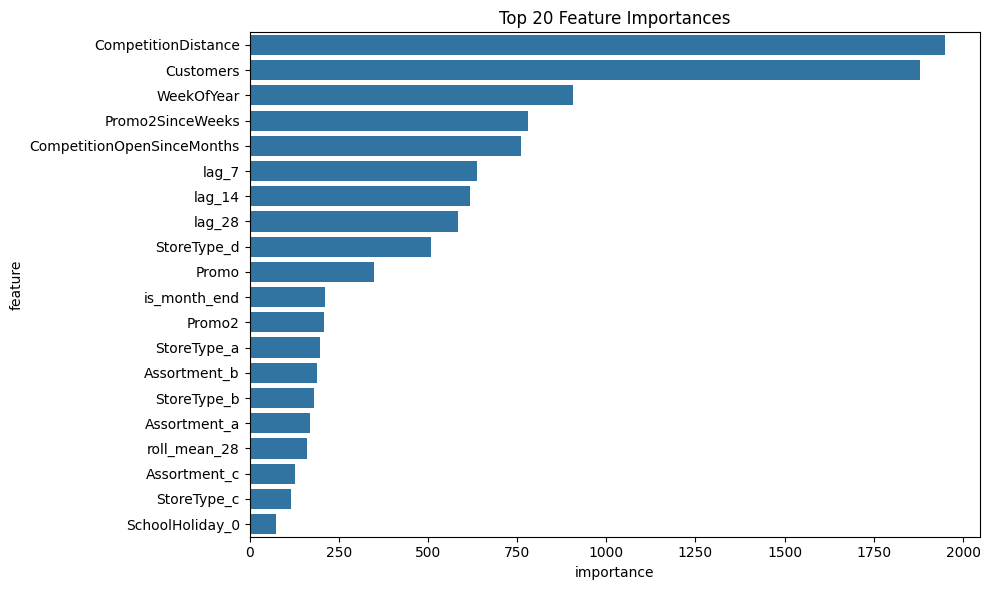

                       feature  importance
1          CompetitionDistance        1950
0                    Customers        1878
6                   WeekOfYear         906
5             Promo2SinceWeeks         781
2   CompetitionOpenSinceMonths         760
7                        lag_7         638
8                       lag_14         618
9                       lag_28         583
18                 StoreType_d         509
3                        Promo         349
14                is_month_end         212
4                       Promo2         209
15                 StoreType_a         198
20                Assortment_b         190
16                 StoreType_b         180
19                Assortment_a         169
11                roll_mean_28         162
21                Assortment_c         128
17                 StoreType_c         116
25             SchoolHoliday_0          74


In [13]:
# Predictions on a holdout or last chunk
X_train_full = X[X["Date"] < "2015-07-01"] if "Date" in X.columns else X


# Feature Importance (LightGBM)
model_steps = best_pipeline.named_steps
lgbm = model_steps['regressor']
# get features names
pre = best_pipeline.named_steps['preprocessor']
# get features names after preprocessing
def get_features_names(preprocessor):
    names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            names.extend(cols)
        elif name == 'cat':
            ohe = transformer.named_steps['onehot']
            ohe_features = ohe.get_feature_names_out(cols)
            names.extend(ohe_features)
    return names

feature_names = get_features_names(pre)
fi = pd.DataFrame({"feature": feature_names,
                   "importance": lgbm.feature_importances_})
fi = fi.sort_values(by="importance", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(data=fi, x="importance", y="feature")   
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

print(fi)

c:\Users\Alex Marco\Downloads\Sales-Revenue-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


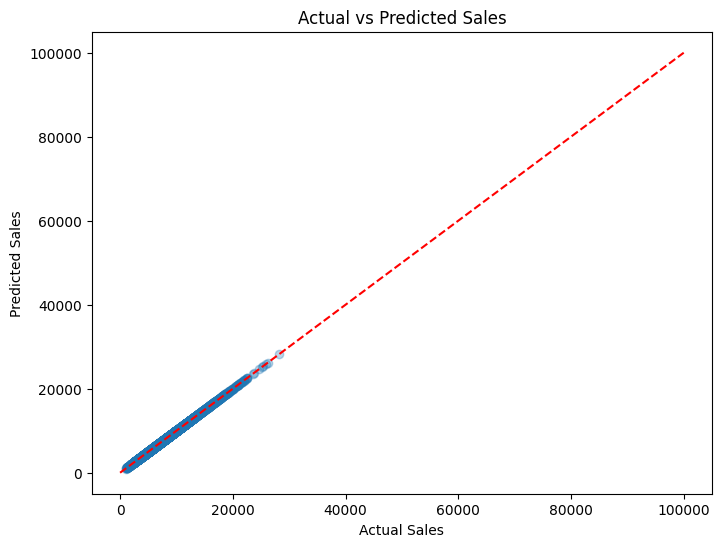

In [14]:
# Actual vs Predicted Plot
y_pred_final_log = best_pipeline.predict(X_train_full)
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_val), np.expm1(y_val), alpha=0.3)
plt.plot([0, 100000], [0, 100000], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


In [15]:
# Print the difference between actual and predicted for the first 10 records
comparison = pd.DataFrame({
    "Actual": np.expm1(y_train_full).reset_index(drop=True),
    "Predicted": np.expm1(y_pred_final_log)
}).head(11)
print(comparison)

NameError: name 'y_train_full' is not defined

### 📒 Retraining and Saving Pipeline

In [ ]:
# Fit on full data
best_pipeline.fit(X, np.log1p(y))   
print("Final model fitted on all data.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 51171, number of used features: 26
[LightGBM] [Info] Start training from score 2.282577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [16]:
from joblib import dump, load
import json, os
from datetime import datetime, timezone

os.makedirs("models", exist_ok=True)

# Save model
pipeline_path = "models/pipeline_final.joblib"
dump(best_pipeline, pipeline_path)

# prepare metadata
now_utc = datetime.now(timezone.utc)

metadata = {
    "pipeline_file": pipeline_path,
    "trained_at": now_utc.strftime("%Y-%m-%d %H:%M:%S UTC"),
    "num_cols": list(num_cols) if not isinstance(num_cols, int) else num_cols,
    "cat_cols": list(cat_cols) if not isinstance(cat_cols, int) else cat_cols,
    "target_transform": "log1p",
    "training_rows": int(X.shape[0]),
    "training_cols": int(X.shape[1]),
}

# add model params
try:
    metadata["model_params"] = best_pipeline.named_steps["regressor"].get_params()
except Exception:
    metadata["model_params"] = {}

# Add CV/holdout metrics
metadata["cv_rmse"] = float(study.best_trial.value)  # ensure JSON serializable

# Save metadata
with open("models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Model and metadata saved.")
print("Saved Pipeline:----->", pipeline_path)


Model and metadata saved.
Saved Pipeline:-----> models/pipeline_final.joblib
